In [1]:
# Dependencies
from sqlalchemy import create_engine
from sqlalchemy import Column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
Base = declarative_base()
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import pandas as pd
from datetime import timedelta
import datetime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib import style
style.use('seaborn')
import matplotlib
from sqlalchemy import func
import matplotlib.pyplot as plt; plt.rcdefaults()

# Create database connection
engine = create_engine('sqlite:///hawaii.sqlite')
Base.metadata.create_all(engine)

# Declare a Base
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

# Assign classes to a variables
Station = Base.classes.stations
Measurement = Base.classes.measurements

# Create a session
session = Session(engine)

In [2]:
# Query precipitations from measurement data
percip = session.query(Measurement.date, Measurement.prcp).all()

# Load the results into a dataframe, find latest record's date, identify one year prior to latest date and filter out old records
precipitation = pd.DataFrame(percip, columns=['date', 'prcp'])
precipitation['date'] = pd.to_datetime(precipitation['date'])
precipitation["previousyear"] = precipitation["date"] - timedelta(days=365)
prevyear = [precipitation.previousyear.max()]
precipitation["diff"] = precipitation["date"] - (pd.to_datetime(prevyear))
precipitation = precipitation[(precipitation['diff'] > "0 days") == True]
precipitation['date'] = precipitation['date'].dt.date
precipitation = precipitation.drop('previousyear', 1)
precipitation = precipitation.drop('diff', 1)
precipitation.set_index('date', inplace=True,)

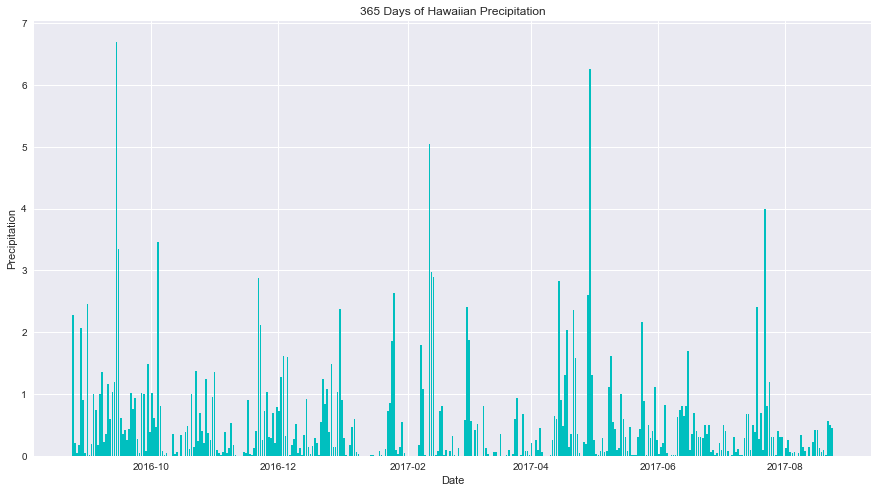

In [3]:
# Plot precipitation records
x_axis = precipitation.index.tolist()
y_axis = precipitation["prcp"].tolist()
plt.figure(figsize=(15,8))
plt.bar(x_axis, y_axis, color='c', align="edge")
plt.title("365 Days of Hawaiian Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.savefig('Percipitation.png')
plt.show()

In [4]:
# Calculate the total number of stations.
query = session.query(Station).all()
station_list = session.query(Station)
total = 0
for station in station_list:
    total = total + 1
print("There are " + str(total) + " total weather stations.")

There are 9 total weather stations.


In [5]:
# Order stations by most active
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [6]:
# Query tobs from measurement data
tobs = session.query(Measurement.station, Measurement.date, Measurement.tobs).all()

# Load the results into a dataframe, find latest record's date, identify one year prior to latest date and filter out old records
temps = pd.DataFrame(tobs, columns=['station','date', 'tobs'])
temps['date'] = pd.to_datetime(temps['date'])
temps["previousyear"] = temps["date"] - timedelta(days=365)
prevyear = [temps.previousyear.max()]
temps["diff"] = temps["date"] - (pd.to_datetime(prevyear))
temps = temps[(temps['diff'] > "0 days") == True]
temps['date'] = temps['date'].dt.date
temps['temp'] = temps['tobs']
stationtemps = temps[(temps['station'] == "USC00519281") == True]
stationtemps = stationtemps.drop('previousyear', 1)
stationtemps = stationtemps.drop('diff', 1)
stationtemps = stationtemps.drop('tobs', 1)
stationtemps = stationtemps.drop('date', 1)
stationtemps = stationtemps.drop('station', 1)
vacationtemps = temps.drop('diff', 1)
vacationtemps = vacationtemps.drop('tobs', 1)
vacationtemps = vacationtemps.drop('station', 1)
vacationtemps = vacationtemps.drop('previousyear', 1)
vacationtemps["nextyear"] = vacationtemps["date"] + timedelta(days=365)
vacationtemps = vacationtemps.drop('date', 1)

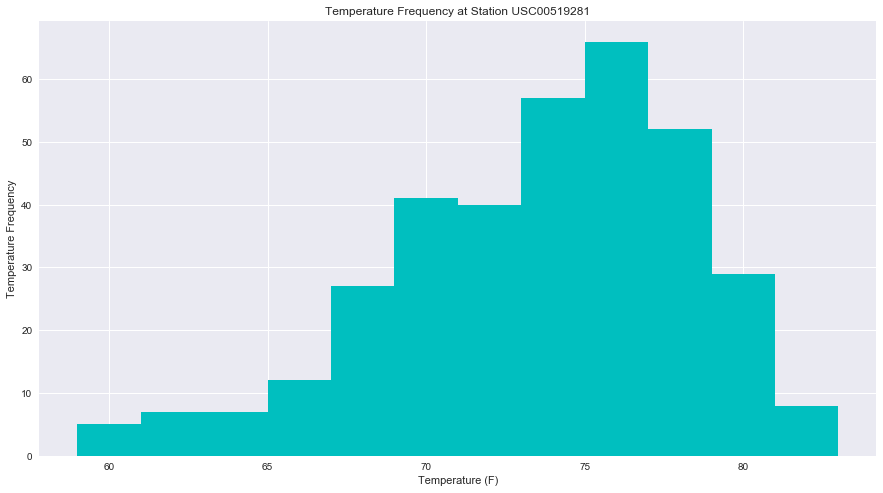

In [7]:
# Plot the results as a histogram with bins=12
plt.figure(figsize=(15,8))
matplotlib.pyplot.hist(stationtemps["temp"], bins=12, color='c')
plt.title("Temperature Frequency at Station USC00519281")
plt.xlabel("Temperature (F)")
plt.ylabel("Temperature Frequency")
plt.savefig('USC00519281Frequency.png')
plt.show()

Please enter the dates of your upcoming vacation in %Y-%m-%d format.
Your end date must be on or before 8-23-2018.

Start date: 2018-01-01
End date: 2018-01-30

Here is the predicted forecast for your trip, based on weather data from last year at the same time:


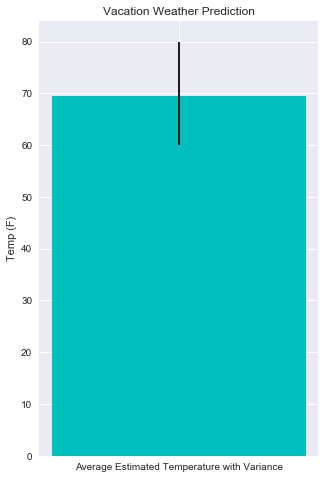

In [168]:
# Create function

def calc_temps(start, end):
    startdate = pd.to_datetime(start)
    enddate = pd.to_datetime(end)
    tempdata = []
    xaxis = []
    for index, row in vacationtemps.iterrows():
        nextyear = pd.to_datetime(row[1])
        if nextyear >= startdate and nextyear <= enddate:
            tempdata.append(row[0])
    label = ['temp']
    temps = pd.DataFrame(tempdata, columns=label)
    max = temps["temp"].max()
    min = temps["temp"].min()
    avg = np.round(temps["temp"].mean(), decimals=1) 
    lowvar = avg - min
    highvar = max - avg 
    plt.figure(figsize=(5,8))
    plt.bar(x_pos, avg, color='c', yerr=[[lowvar],[highvar]])
    plt.ylabel("Temp (F)")
    plt.title("Vacation Weather Prediction")
    plt.xticks([0], ['Average Estimated Temperature with Variance'])
    plt.savefig('PredictedVacationWeather.png')
    print ("")
    print ("Here is the predicted forecast for your trip, based on weather data from last year at the same time:")
    plt.show()
    
# Call function

print ("Please enter the dates of your upcoming vacation in %Y-%m-%d format.")
print ("Your end date must be on or before 8-23-2018.")
print ("")
calc_temps(input("Start date: "), input("End date: "))

Now that you have completed your initial analysis, design a Flask api based on the queries that you have just developed.
Use FLASK to create the following routes:


/api/v1.0/precipitation =

Query for the dates and temperature observations from the last year.
Convert the query results to a Dictionary using date as the key and tobs as the value.
Return the json representation of your dictionary.


/api/v1.0/stations =

Return a json list of stations from the dataset.


/api/v1.0/tobs =

Return a json list of Temperature Observations (tobs) for the previous year


/api/v1.0/<start> and /api/v1.0/<start>/<end> =

Return a json list of the minimum temperature, the average temperature, and the max temperature for
a given start or start-end range.
When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.
When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.


You will need to join the station and measurement tables for some of the analysis queries.
Use Flask jsonify to convert your api data into a valid json response object.